In [1]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install qiskit_algorithms

Note: you may need to restart the kernel to use updated packages.


In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from copy import deepcopy as copy

import qiskit
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Gate
from qiskit.circuit.library.standard_gates import UGate
from qiskit.exceptions import QiskitError
import numpy as np
from typing import List, Optional
import matplotlib.pyplot as plt
from qiskit_machine_learning import QiskitMachineLearningError
import itertools
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA, SPSA

%matplotlib inline

In [198]:
data = pd.read_csv('HI-Small_Trans.csv')

In [199]:
data

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.340000,US Dollar,3697.340000,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.010000,US Dollar,0.010000,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.570000,US Dollar,14675.570000,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.970000,US Dollar,2806.970000,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.970000,US Dollar,36682.970000,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0


In [200]:
# Y feature: is laundering

In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [202]:
data['Is Laundering'].value_counts()

Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

In [203]:
x0 = []
for i in data['Amount Received']:
    if str(i) == 'nan': x0.append(None)
    else: x0.append(i)

In [204]:
currency_dict = {
    'US Dollar':0, 'Bitcoin':1, 'Euro':2, 'Australian Dollar':3, 'Yuan':4,
    'Rupee':5, 'Mexican Peso':6, 'Yen':7, 'UK Pound':8, 'Ruble': 9,
    'Canadian Dollar':10, 'Swiss Franc':11, 'Brazil Real':12, 'Saudi Riyal':13,
    'Shekel':14
}

x1_unfiltered = list(data['Receiving Currency'])
x1 = []
for currency in x1_unfiltered:
    currency_vect = [0 for i in range(15)]
    if str(currency) != 'nan': currency_vect[currency_dict[currency]] = 1.  
    x1.append(currency_vect)

In [205]:
x2 = []
for i in data['Amount Paid']:
    if str(i) == 'nan': x2.append(None)
    else: x2.append(i)

In [206]:
payment_currency_dict = {
    'US Dollar': 0, 'Bitcoin': 1, 'Euro': 2, 'Australian Dollar': 3, 'Yuan': 4,
    'Rupee': 5, 'Yen': 6, 'Mexican Peso': 7, 'UK Pound': 8, 'Ruble': 9,
    'Canadian Dollar': 10, 'Swiss Franc': 11, 'Brazil Real': 12, 'Saudi Riyal': 13,
    'Shekel': 14
}

x3_unfiltered = list(data['Payment Currency'])
x3 = []
for currency in x3_unfiltered:
    currency_vect = [0 for i in range(15)]
    if str(currency) != 'nan':
        currency_vect[payment_currency_dict[currency]] = 1.
    x3.append(currency_vect)

In [207]:
payment_format_dict = {
    'Reinvestment': 0, 'Cheque': 1, 'Credit Card': 2, 'ACH': 3, 'Cash': 4,
    'Wire': 5, 'Bitcoin': 6
}

x4_unfiltered = list(data['Payment Format'])
x4 = []
for payment in x4_unfiltered:
    payment_vect = [0 for i in range(7)]
    if str(payment) != 'nan':
        payment_vect[payment_format_dict[payment]] = 1.
    x4.append(payment_vect)

In [208]:
x5 = []
for i in range(len(data['From Bank'])):
    if data['From Bank'].values[i] == data['To Bank'].values[i]:
        x5.append(0)
    else:
        x5.append(1.)

In [209]:
x6 = []
for i in range(len(data['Account'])):
    if data['Account'].values[i] == data['Account.1'].values[i]:
        x6.append(0)
    else:
        x6.append(1.)

In [210]:
y = []
x = []

for i, launder in enumerate(data['Is Laundering']):
    if str(launder) == "nan" or x0[i] == None or x2[i] == None: continue
    y.append(int(launder))
    x.append([x0[i]] + x1[i] + [x2[i]] + x3[i] + x4[i] + [x5[i]] + [x6[i]])

In [211]:
x = np.array(x)
y = np.array(y)

x, y = shuffle(x, y, random_state=42)

In [212]:
# Create smaller dataset to run SPSA algorithm quicker
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

sampled_class_0_indices = np.random.choice(class_0_indices, 1000, replace=False)
sampled_class_1_indices = np.random.choice(class_1_indices, 500, replace=False)

sampled_indices = np.concatenate([sampled_class_0_indices, sampled_class_1_indices])
x = x[sampled_indices]
y = y[sampled_indices]

y = [-1 if j == 0 else j for j in y]

In [213]:
x = np.array(x)
y = np.array(y)

x, y = shuffle(x, y, random_state=42)

In [214]:
sample_train, sample_test, label_train, label_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# Reduce dimensions
n_dim = 32
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

print(sample_train[0])

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

print(sample_train[0])

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

print(sample_train[0])

[-5.41777870e+06 -1.97996455e+05  1.04772691e+00 -6.96965030e-01
  6.01769399e-01 -2.77910275e-01 -8.40111936e-02  4.90610947e-02
  4.68862988e-02 -1.91870511e-02 -2.24492612e-02 -3.38027083e-02
 -3.99864862e-03 -3.69989929e-03  5.69140390e-03  6.45776085e-03
  8.16943612e-03  1.58539534e-03 -2.63811031e-03 -9.77453645e-03
 -2.99396780e-03 -3.34803187e-02 -9.27500017e-04  6.51265610e-03
 -7.11640017e-04  4.85678877e-04  4.24516431e-04  2.54914186e-05
 -1.66374477e-05  3.70700689e-04 -6.31041328e-10  2.81829762e-11]
[-6.68839788e-02 -2.17343900e-02  1.38053966e+00 -1.23147282e+00
  1.16008606e+00 -5.86962858e-01 -1.95974660e-01  1.49820582e-01
  1.50020184e-01 -6.56400311e-02 -8.05638059e-02 -1.23186687e-01
 -1.52308031e-02 -1.47713891e-02  2.33636887e-02  2.82809773e-02
  3.70140172e-02  7.32298968e-03 -1.30474126e-02 -5.71207001e-02
 -2.06944751e-02 -2.66408500e-01 -9.96956972e-03  8.28157219e-02
 -1.62219013e-02  1.73878168e-02  1.78425650e-02  1.25384148e-03
 -8.19085479e-04  2.0342

In [ ]:
# NOTE: Code missing: Derivation of angles to embed data points as quantum states, creation of general amplitude embedding 
# circuit, and strongly entangling layers ansatz. These are all part of a future patent package. Contact developer for more
# details.

In [227]:
np.random.seed(42)

In [228]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [229]:
objective_func_vals = []

estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=SPSA(maxiter=100, learning_rate=None, perturbation=None), callback=callback_graph
)

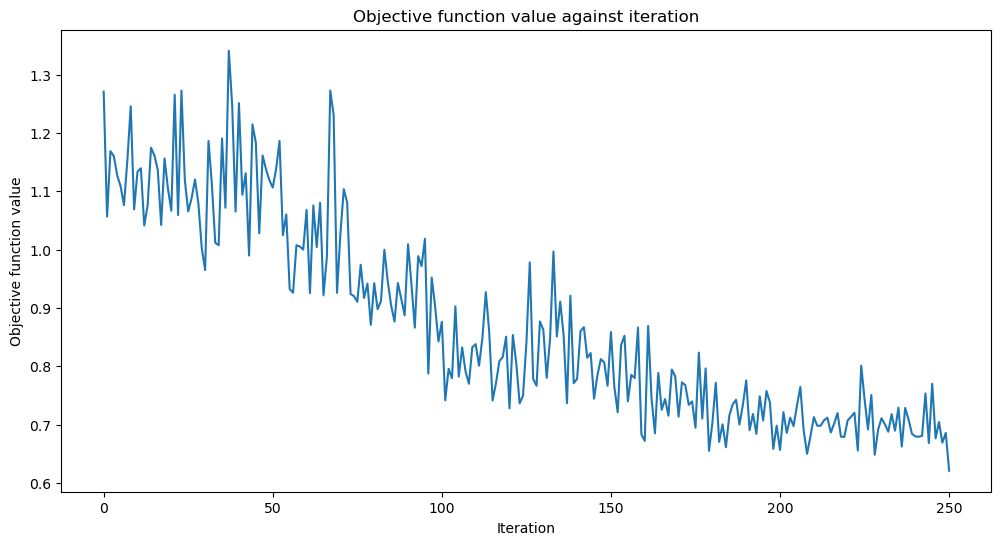

Classifier Accuracy: 87.67%


In [230]:
plt.rcParams["figure.figsize"] = (12, 6)
estimator_classifier.fit(sample_train, label_train)
plt.rcParams["figure.figsize"] = (6, 4)
score = estimator_classifier.score(sample_test, label_test)
print(f"Classifier Accuracy: {score * 100:.2f}%")

In [231]:
estimator_classifier.weights

array([-1.07934488,  1.27436149,  2.05656413,  2.16373338,  1.01581029,
       -0.05594453,  0.80806746, -0.8425139 ,  1.22562687,  0.1292986 ,
       -0.42187008,  3.1789392 , -0.66461915, -0.51187004, -0.58266923,
        1.76176334, -0.52486828,  2.5641323 , -1.75892192,  0.36667157,
        0.87880076,  1.58089095, -0.9239861 ,  1.27239161,  1.21981044,
       -0.2540609 ,  1.23222573,  0.38974277,  0.53764713, -1.92672124,
       -1.13634975,  1.35982485,  0.09116887, -0.09921517, -1.27045762,
       -0.14952219, -2.30539819,  1.00010832, -1.58396457,  1.45630539,
        0.31433403,  1.435959  ,  1.17737147,  1.0707963 ,  3.75381574,
       -0.42616161,  2.3232868 , -2.77577384, -0.78030676,  2.37108267,
        1.85745117,  0.51981783,  0.21039547,  1.16401725,  3.47828018,
        0.77475117,  0.26720983,  5.26305349, -1.12919323,  1.03492316])